# Deep learning techniques to identify the composer of a music piece

**Objective**  
The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

**Dataset**  
The project will use a dataset consisting of musical scores from various composers. The dataset contain MIDI files and sheet music of compositions from well-known classical composers like Bach, Beethoven, Chopin, Mozart, Schubert, etc. The dataset should be labeled with the name of the composer for each score.

## Data Collection

### Install required libraries

In [1]:
# Import all dependent libraries
import os
import csv
import zipfile
import shutil

from pathlib import Path
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
import keras.optimizers
import tensorflow as tf


# Music related libraries
import music21
from music21 import converter, instrument, note, chord, tempo

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Deep Learning Libraries
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.preprocessing import MinMaxScaler
from keras.utils import pad_sequences # not used , should we remove it?
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
# Function to check if running from colab
def is_running_on_colab():
  return 'google.colab' in str(get_ipython())

if is_running_on_colab():
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive' , force_remount=True)
  root_path = '/content/drive/MyDrive/AAI-511-IN2 Neural Networks and Deep Learning/Project'
else:
  print('Not running on Colab')
  root_path = '.'

Running on Colab
Mounted at /content/drive


In [3]:
# File path in Google Drive
file_path = os.path.join(root_path, 'Composer_Dataset.zip')

# Extract file path
# Check if Kaggle dataset already exists
extract_path = os.path.join(root_path, 'Kaggle_Composer_Dataset')

if not os.path.exists(extract_path):
    extract_path = os.path.join(root_path, 'Composer_Dataset')

print(f"Using dataset: {extract_path}")

# Dataset folders
path = Path(extract_path)
if "Kaggle_Composer_Dataset" in path.name:
    dataset_path = extract_path
else:
    dataset_path = os.path.join(extract_path, 'Composer_Dataset/NN_midi_files_extended')
print(f"Using extracted dataset: {dataset_path}")

# CSV index file
csv_file = os.path.join(dataset_path, 'composer_dataset_index.csv')

Using dataset: /content/drive/MyDrive/AAI-511-IN2 Neural Networks and Deep Learning/Project/Kaggle_Composer_Dataset
Using extracted dataset: /content/drive/MyDrive/AAI-511-IN2 Neural Networks and Deep Learning/Project/Kaggle_Composer_Dataset


In [ ]:
# Check if folder already exists
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [ ]:
# Function to clean the folders
def delete_hidden_folders(root_folder):
    for root, dirs, _ in os.walk(root_folder):
        for d in dirs:
            if d.startswith('.'):
                dir_path = os.path.join(root, d)
                print(f"Deleting hidden folder: {dir_path}")
                shutil.rmtree(dir_path)
            elif d == '__MACOSX':
                dir_path = os.path.join(root, d)
                print(f"Deleting __MACOSX folder: {dir_path}")
                shutil.rmtree(dir_path)

# Run this on the outer Composer_Dataset
delete_hidden_folders(extract_path)

## Data Pre-processing

In [ ]:
# Function to create index files
def create_midi_file_index_csv(root_dir, output_csv):
    rows = []

    path = Path(root_dir)
    if "Kaggle_Composer_Dataset" in path.name:
        split_folders = ['train', 'test', 'val']
    else:
        split_folders = ['train', 'test', 'dev']

    for split in split_folders:
        split_path = os.path.join(root_dir, split)
        if not os.path.isdir(split_path):
            continue

        for composer in os.listdir(split_path):
            composer_path = os.path.join(split_path, composer)
            if not os.path.isdir(composer_path) or composer.startswith('.'):
                continue

            for filename in os.listdir(composer_path):
                if not filename.endswith('.mid') or filename.startswith('.'):
                    continue

                filepath = os.path.join(split, composer, filename)
                rows.append({
                    'split': split,
                    'composer': composer,
                    'filename': filename,
                    'filepath': filepath
                })

    # Write to CSV
    with open(output_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['split', 'composer', 'filename', 'filepath'])
        writer.writeheader()
        writer.writerows(rows)

    print(f"CSV created: {output_csv} with {len(rows)} entries.")

In [ ]:
# Create index csv file
create_midi_file_index_csv(root_dir=dataset_path, output_csv=csv_file)

CSV created: ./Kaggle_Composer_Dataset/composer_dataset_index.csv with 1660 entries.


## Feature Extraction

In [ ]:
# Function to extract features
def extract_features_from_midi(filepath):
    try:
        midi = converter.parse(filepath)

        # Get tempo (default to 120 if not found)
        bpm = 120
        tempo_indications = midi.flat.getElementsByClass(tempo.MetronomeMark)
        if tempo_indications:
            bpm = tempo_indications[0].number

        notes = []
        durations = []
        pitches = []

        for element in midi.recurse():
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
                durations.append(element.duration.quarterLength)
                pitches.append(element.pitch.midi)
            elif isinstance(element, chord.Chord):
                chord_name = '.'.join(str(n) for n in element.normalOrder)
                notes.append(chord_name)
                durations.append(element.duration.quarterLength)
                pitches.extend(p.midi for p in element.pitches)

        # Chord features from chordified stream
        chordified = midi.chordify()
        chord_names = []
        major_count = 0
        minor_count = 0

        for c in chordified.recurse().getElementsByClass('Chord'):
            name = c.pitchedCommonName
            if name and 'chord' in name:
                chord_names.append(name)
                if c.quality == 'major':
                    major_count += 1
                elif c.quality == 'minor':
                    minor_count += 1

        total_chords = major_count + minor_count

        return {
            'num_events': len(notes),
            'unique_events': len(set(notes)),
            'avg_duration': sum(durations) / len(durations) if durations else 0,
            'tempo': bpm,
            'avg_pitch': sum(pitches) / len(pitches) if pitches else 0,
            'pitch_range': max(pitches) - min(pitches) if pitches else 0,
            'note_density': len(notes) / midi.highestTime if midi.highestTime > 0 else 0,
            'chord_diversity': len(set(chord_names)),
            'major_ratio': major_count / total_chords if total_chords > 0 else 0,
            'minor_ratio': minor_count / total_chords if total_chords > 0 else 0,
            'note_sequence': ' '.join(notes[:100])  # preview of first 100 events
        }

    except Exception as e:
        return {
            'num_events': 0,
            'unique_events': 0,
            'avg_duration': 0,
            'tempo': 0,
            'avg_pitch': 0,
            'pitch_range': 0,
            'note_density': 0,
            'chord_diversity': 0,
            'major_ratio': 0,
            'minor_ratio': 0,
            'note_sequence': '',
            'error': str(e)
        }

In [ ]:
# Load your previously generated CSV
df = pd.read_csv(csv_file)

# Collect features
features = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    full_path = os.path.join(dataset_path, row['filepath'])
    feature = extract_features_from_midi(full_path)
    feature.update({
        'split': row['split'],
        'composer': row['composer'],
        'filename': row['filename'],
        'filepath': row['filepath']
    })
    features.append(feature)

# Save to a new DataFrame
features_df = pd.DataFrame(features)

# Write it to the csv file
features_df.to_csv(csv_file, index=False)

# Print the extracted features
features_df.head()

  0%|                                         | 2/1660 [00:03<39:51,  1.44s/it]/Users/johnny/Library/Python/3.9/lib/python/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
  0%|                                       | 3/1660 [00:06<1:08:38,  2.49s/it]/Users/johnny/Library/Python/3.9/lib/python/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'\x8b\xc8\x82\xcc\x95\\\x91\xe8'>; getting generic Instrument
  warnings.warn(
  1%|▏                                      | 9/1660 [00:56<3:19:32,  7.25s/it]/Users/johnny/Library/Python/3.9/lib/python/site-packages/music21/midi/translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEv

,num_events,unique_events,avg_duration,tempo,avg_pitch,pitch_range,note_density,chord_diversity,major_ratio,minor_ratio,note_sequence,split,composer,filename,filepath,error
0,3218,53,0.580640,122.0,64.404434,58,11.787546,22,0.612245,0.387755,D5 G5 A5 B5 C6 A5 B5 G5 A5 G5 F#5 E5 D5 E5 F#5...,train,Mozart,Mozart_0103.mid,train/Mozart/Mozart_0103.mid,NaN
1,862,85,0.736176,45.0,63.599498,55,6.246377,46,0.784615,0.215385,0.4 0.4 0.4 0.4 0.4 2.4.5 7.11.2 2.7 9.0 11.2....,train,Mozart,Mozart_0063.mid,train/Mozart/Mozart_0063.mid,NaN
2,2688,120,0.591363,165.0,67.948638,60,2.937705,61,0.341935,0.658065,F5 D5 B-4 B-4 E-5 G5 A4 C5 B-4 D5 C5 E-5 D5 F5...,train,Mozart,Mozart_0077.mid,train/Mozart/Mozart_0077.mid,NaN
3,434,16,0.316436,120.0,71.382488,21,2.646341,0,0.000000,0.000000,C4 D4 C4 D4 C4 F4 C4 G4 C4 A4 C4 B4 C4 C5 C4 D...,train,Mozart,Mozart_0088.mid,train/Mozart/Mozart_0088.mid,NaN
4,15528,130,0.483519,135.0,64.320504,65,12.980564,161,0.641144,0.358856,C6 C6 B5 D6 D6 C6 A5 A5 A5 A5 5.7 2.4 C5 D5 E5...,train,Mozart,Mozart_0248.mid,train/Mozart/Mozart_0248.mid,NaN


## Model Building

### Dataset overview

In [4]:
# Load the uploaded dataset
df = pd.read_csv(csv_file)

# Show basic info
df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_events       1660 non-null   int64  
 1   unique_events    1660 non-null   int64  
 2   avg_duration     1660 non-null   float64
 3   tempo            1660 non-null   float64
 4   avg_pitch        1660 non-null   float64
 5   pitch_range      1660 non-null   int64  
 6   note_density     1660 non-null   object 
 7   chord_diversity  1660 non-null   int64  
 8   major_ratio      1660 non-null   float64
 9   minor_ratio      1660 non-null   float64
 10  note_sequence    1619 non-null   object 
 11  split            1660 non-null   object 
 12  composer         1660 non-null   object 
 13  filename         1660 non-null   object 
 14  filepath         1660 non-null   object 
 15  error            41 non-null     object 
dtypes: float64(5), int64(4), object(7)
memory usage: 207.6+ KB


,num_events,unique_events,avg_duration,tempo,avg_pitch,pitch_range,note_density,chord_diversity,major_ratio,minor_ratio,note_sequence,split,composer,filename,filepath,error
0,3218,53,0.580640,122.0,64.404434,58,11.787545787545788,22,0.612245,0.387755,D5 G5 A5 B5 C6 A5 B5 G5 A5 G5 F#5 E5 D5 E5 F#5...,train,Mozart,Mozart_0103.mid,train/Mozart/Mozart_0103.mid,NaN
1,862,85,0.736176,45.0,63.599498,55,6.246376811594203,46,0.784615,0.215385,0.4 0.4 0.4 0.4 0.4 2.4.5 7.11.2 2.7 9.0 11.2....,train,Mozart,Mozart_0063.mid,train/Mozart/Mozart_0063.mid,NaN
2,2688,120,0.591363,165.0,67.948638,60,2.9377049180327868,61,0.341935,0.658065,F5 D5 B-4 B-4 E-5 G5 A4 C5 B-4 D5 C5 E-5 D5 F5...,train,Mozart,Mozart_0077.mid,train/Mozart/Mozart_0077.mid,NaN
3,434,16,0.316436,120.0,71.382488,21,2.6463414634146343,0,0.000000,0.000000,C4 D4 C4 D4 C4 F4 C4 G4 C4 A4 C4 B4 C4 C5 C4 D...,train,Mozart,Mozart_0088.mid,train/Mozart/Mozart_0088.mid,NaN
4,15528,130,0.483519,135.0,64.320504,65,12.980564263322885,161,0.641144,0.358856,C6 C6 B5 D6 D6 C6 A5 A5 A5 A5 5.7 2.4 C5 D5 E5...,train,Mozart,Mozart_0248.mid,train/Mozart/Mozart_0248.mid,NaN


### Data cleaning

In [5]:
# Drop rows where note_sequence is missing or empty
df = df[df['note_sequence'].notnull() & (df['note_sequence'].str.strip() != '')]

# If there's an 'error' column, drop rows where errors were recorded
if 'error' in df.columns:
    df = df[df['error'].isnull() | (df['error'].str.strip() == '')]

# Reset index after filtering
df = df.reset_index(drop=True)

# Convert note_density column to numerical value
df['note_density'] = pd.to_numeric(df['note_density'], errors='coerce')

print(f"Cleaned dataset. Remaining entries: {len(df)}")

Cleaned dataset. Remaining entries: 1619


### Data visualization

In [6]:
# Check number of files per composer and by split
composer_counts = df['composer'].value_counts()
split_counts = df['split'].value_counts()
composer_split_counts = df.groupby(['composer', 'split']).size().unstack(fill_value=0)

# Check missing or error-prone entries
missing_sequences = df['note_sequence'].isnull().sum()
error_files = df['error'].notnull().sum() if 'error' in df.columns else 0

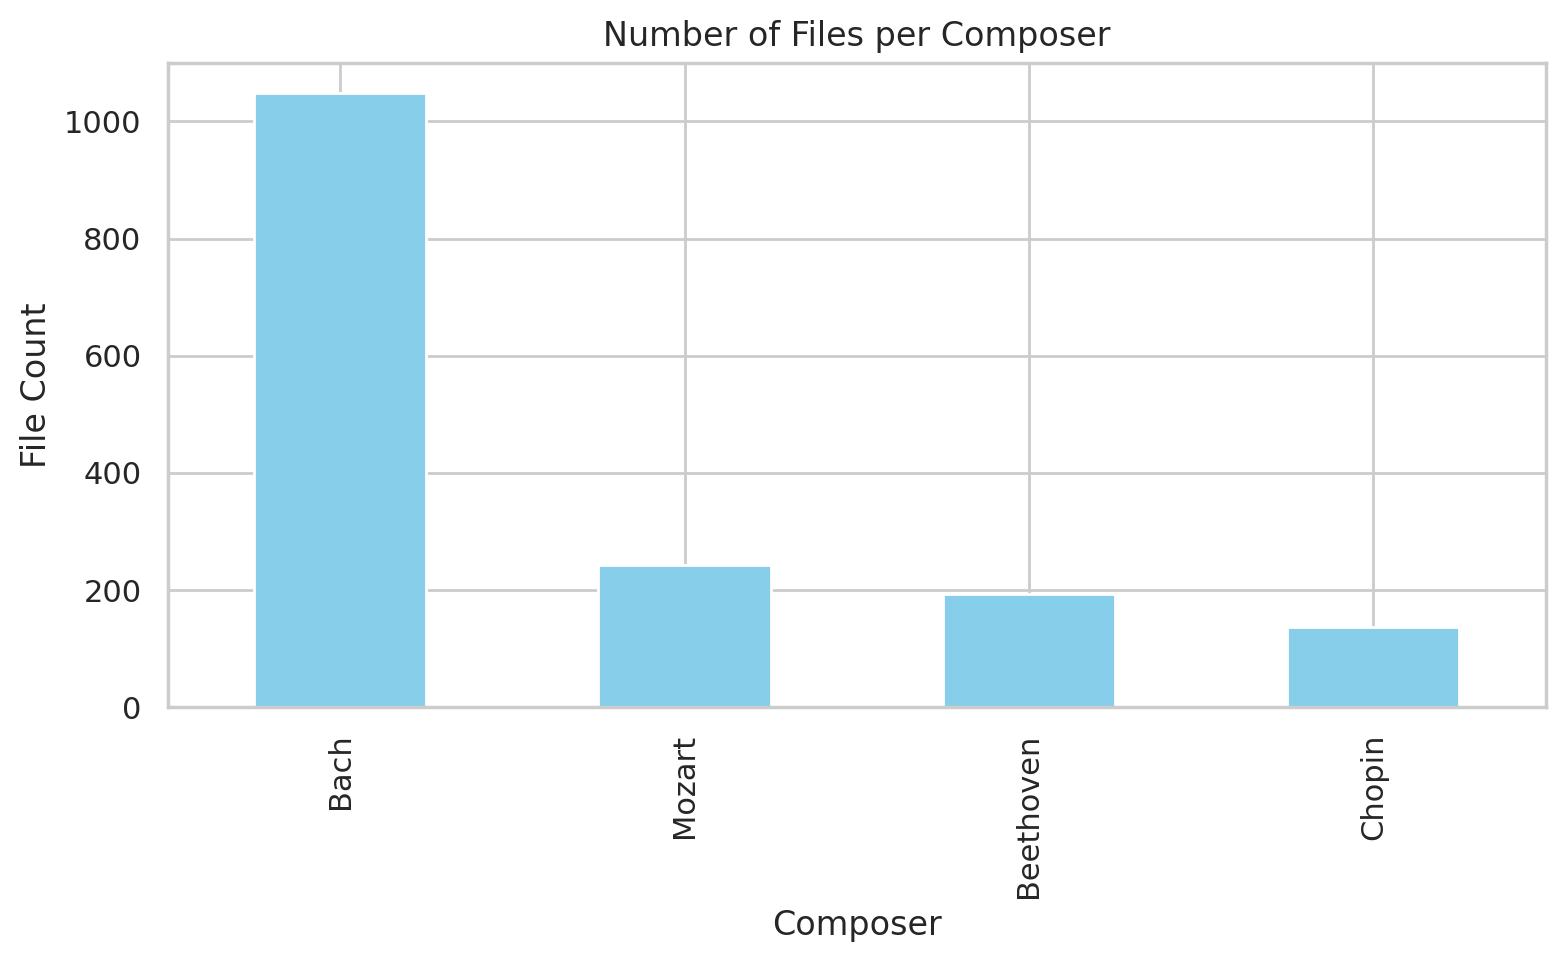

In [7]:
# Set plot style
sns.set(style="whitegrid")

# Number of files per composer
plt.figure(figsize=(8, 5))
composer_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Files per Composer')
plt.ylabel('File Count')
plt.xlabel('Composer')
plt.tight_layout()
plt.show()

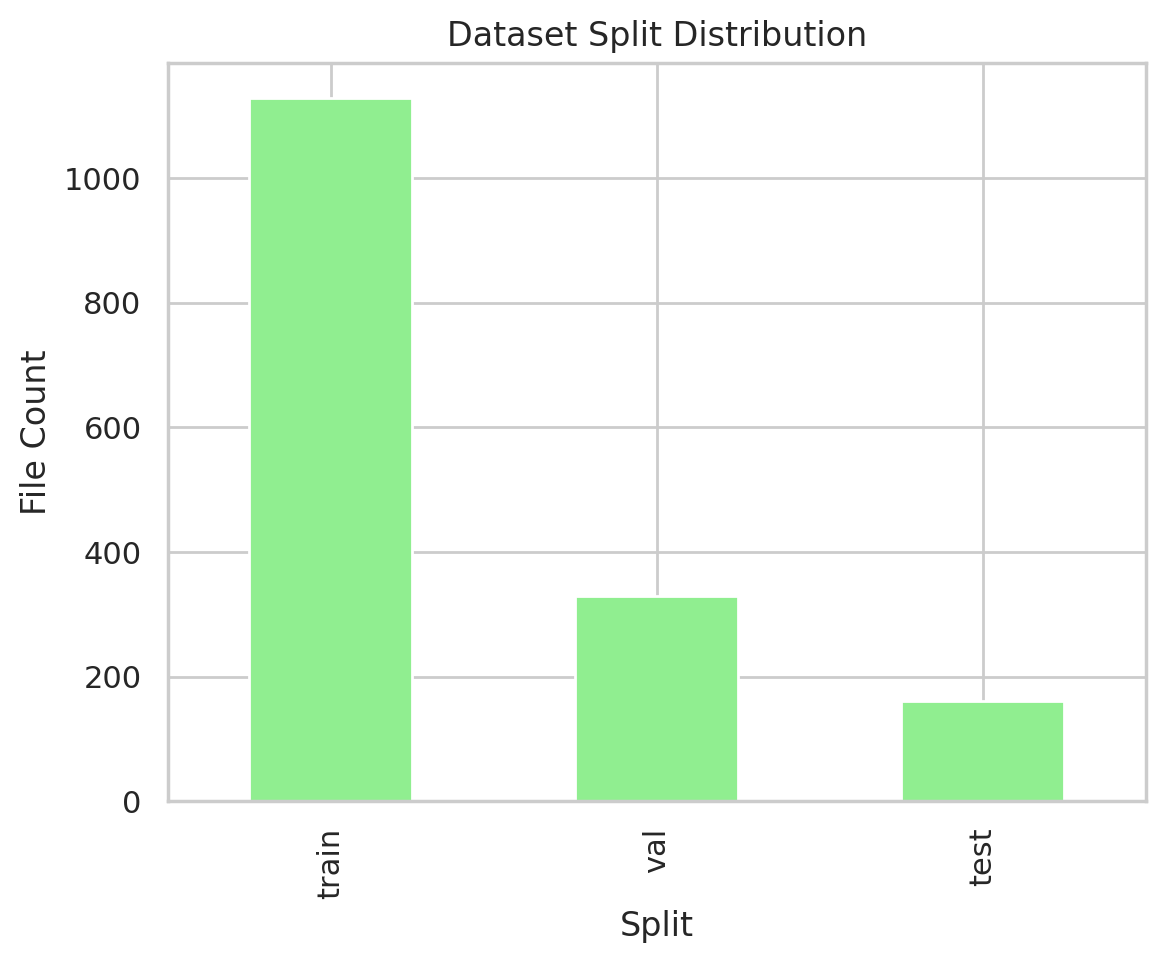

In [8]:
# Split distribution
plt.figure(figsize=(6, 5))
split_counts.plot(kind='bar', color='lightgreen')
plt.title('Dataset Split Distribution')
plt.ylabel('File Count')
plt.xlabel('Split')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

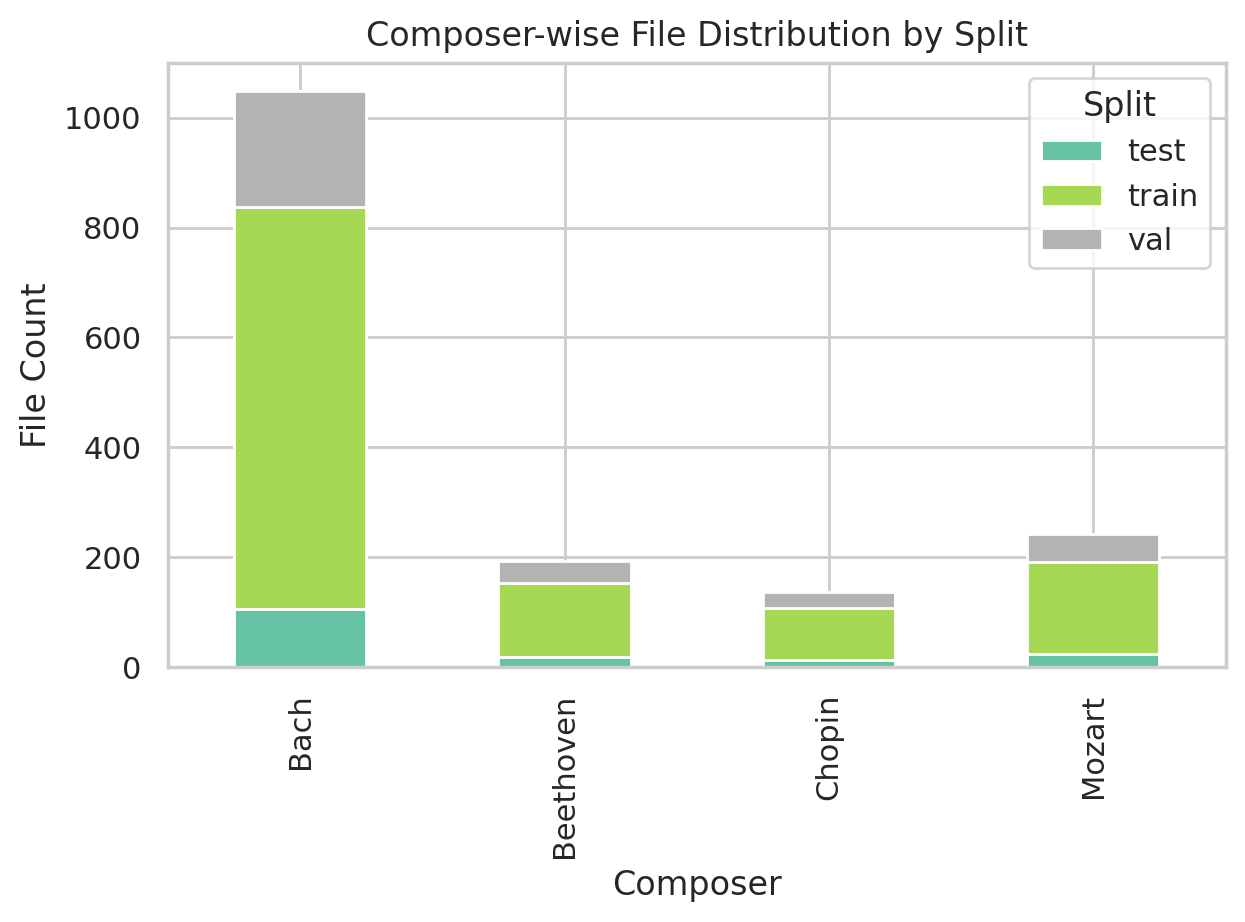

In [9]:
# Composer-wise split
plt.figure(figsize=(10, 6))
composer_split_counts.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Composer-wise File Distribution by Split')
plt.ylabel('File Count')
plt.xlabel('Composer')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

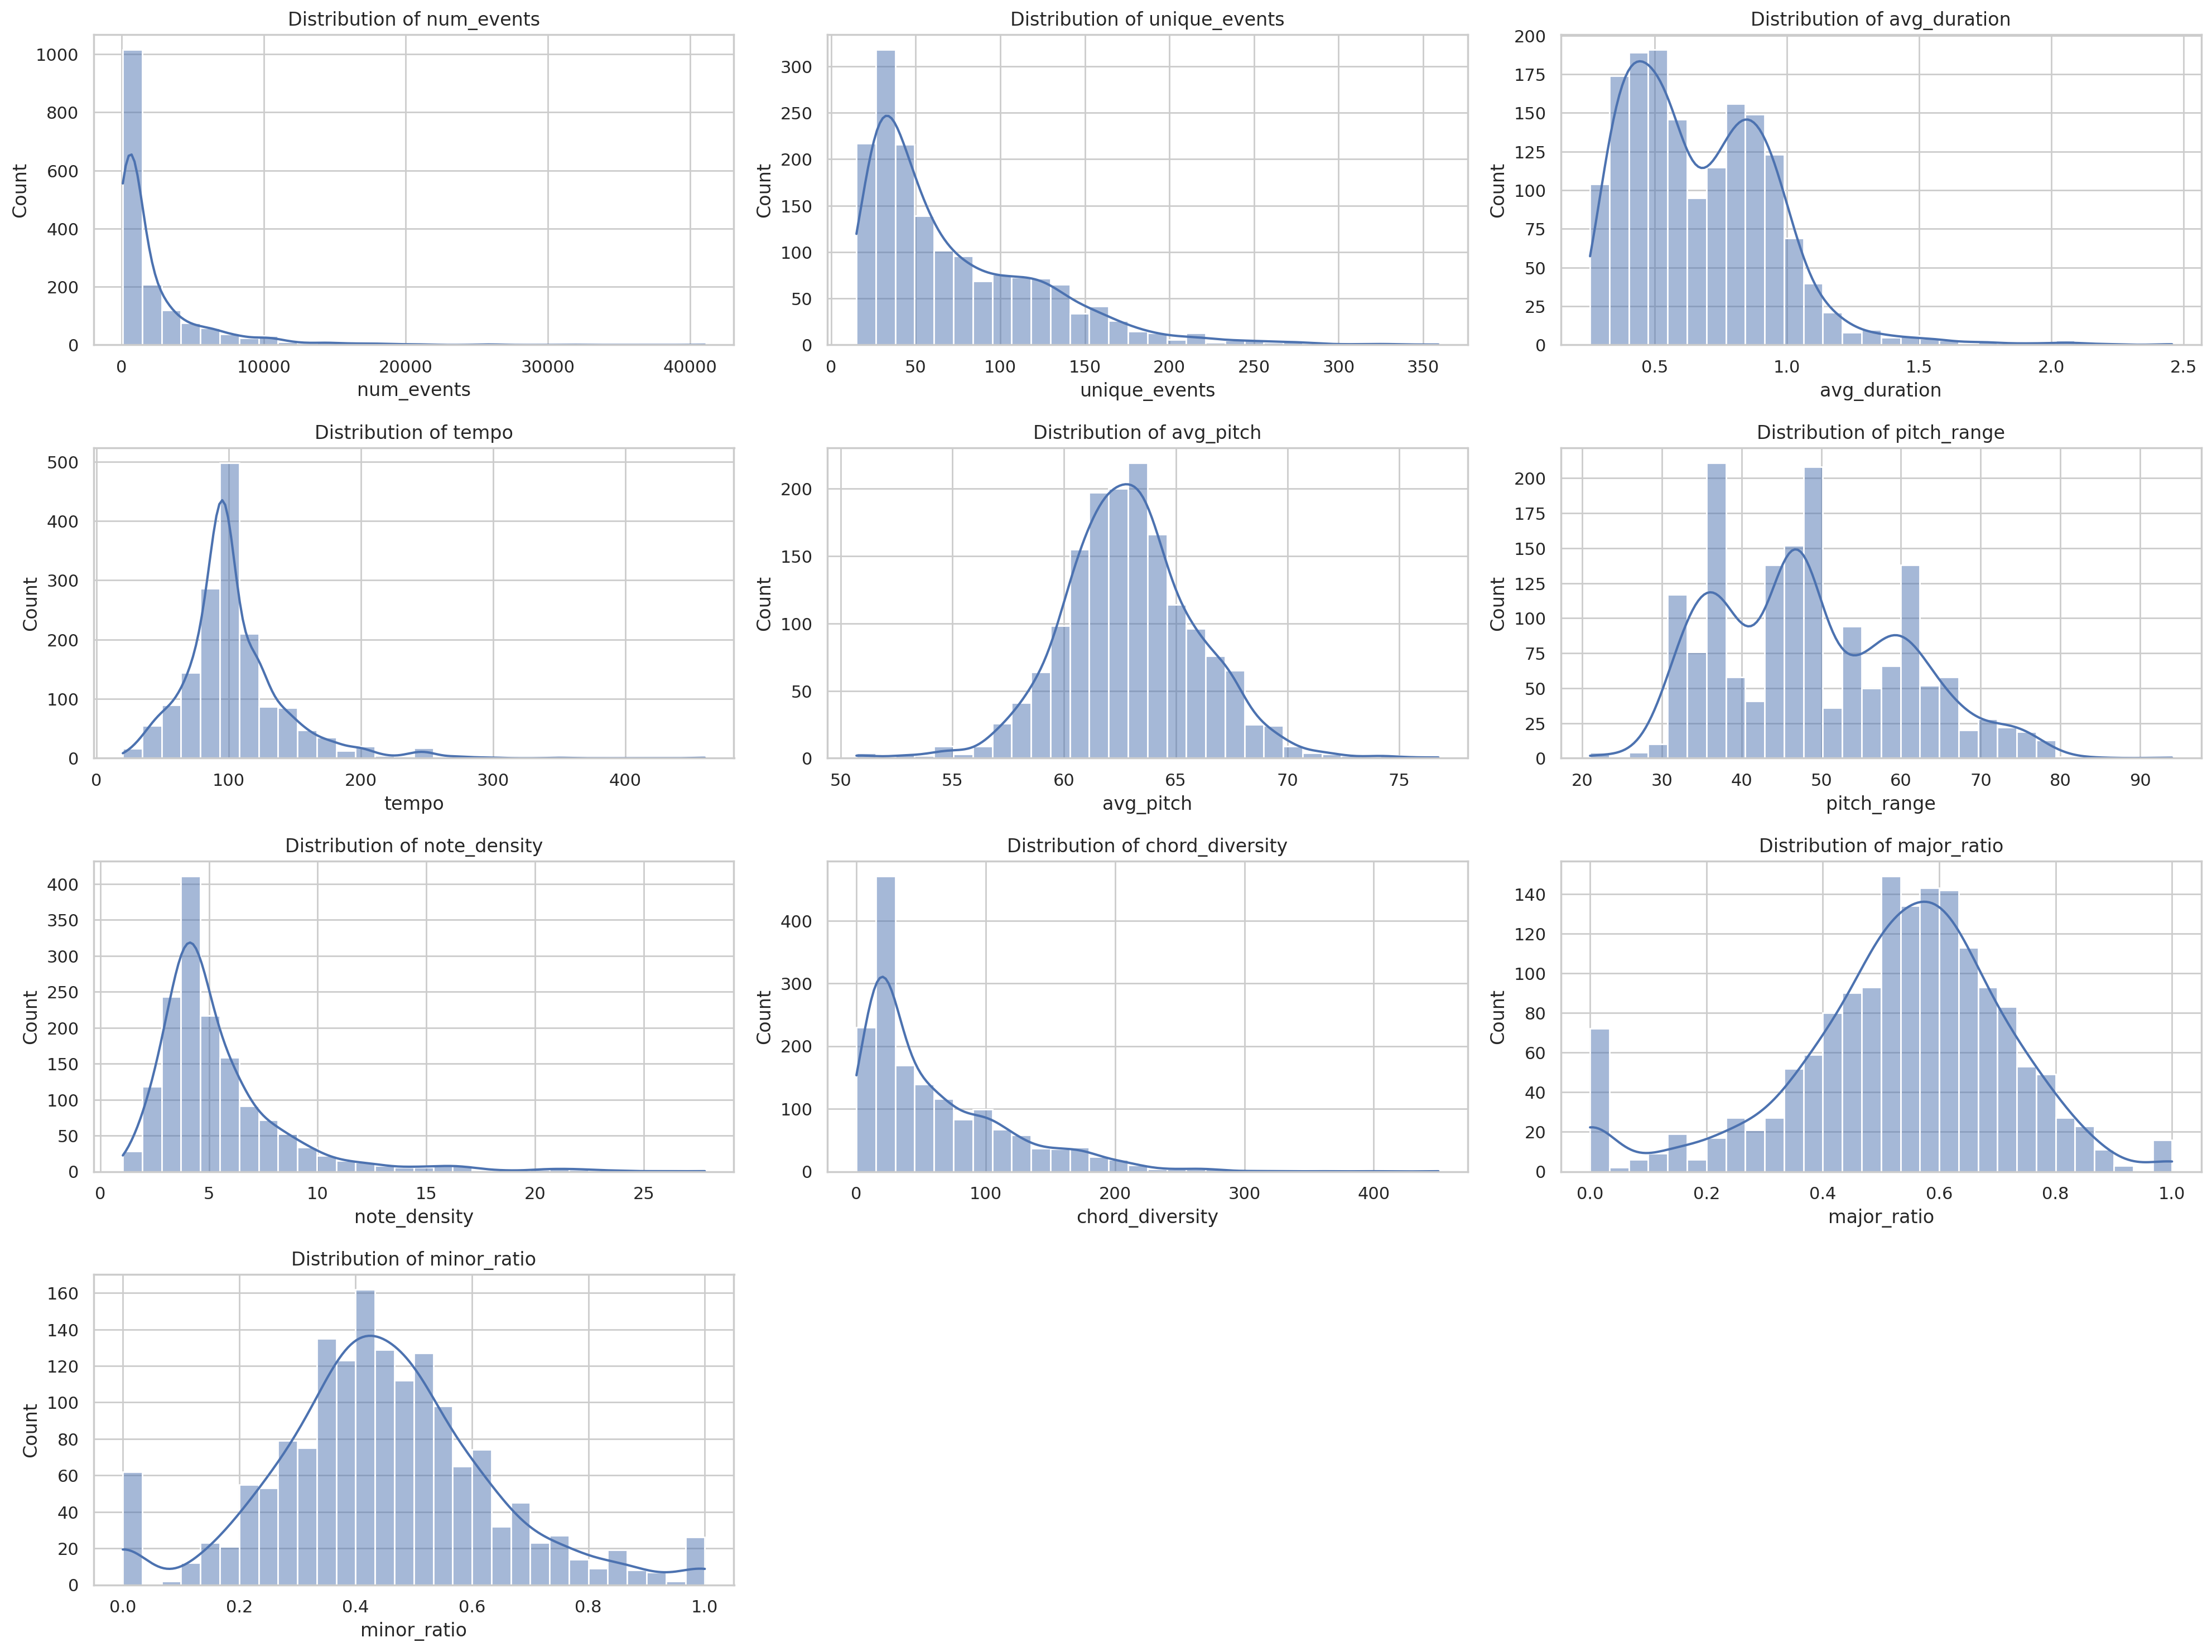

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Features to plot
stat_cols = ['num_events', 'unique_events', 'avg_duration', 'tempo',
             'avg_pitch', 'pitch_range', 'note_density', 'chord_diversity',
             'major_ratio', 'minor_ratio']

# Plot distributions for each statistical feature
plt.figure(figsize=(20, 15))
for i, col in enumerate(stat_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df, x=col, kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### Correlation analysis

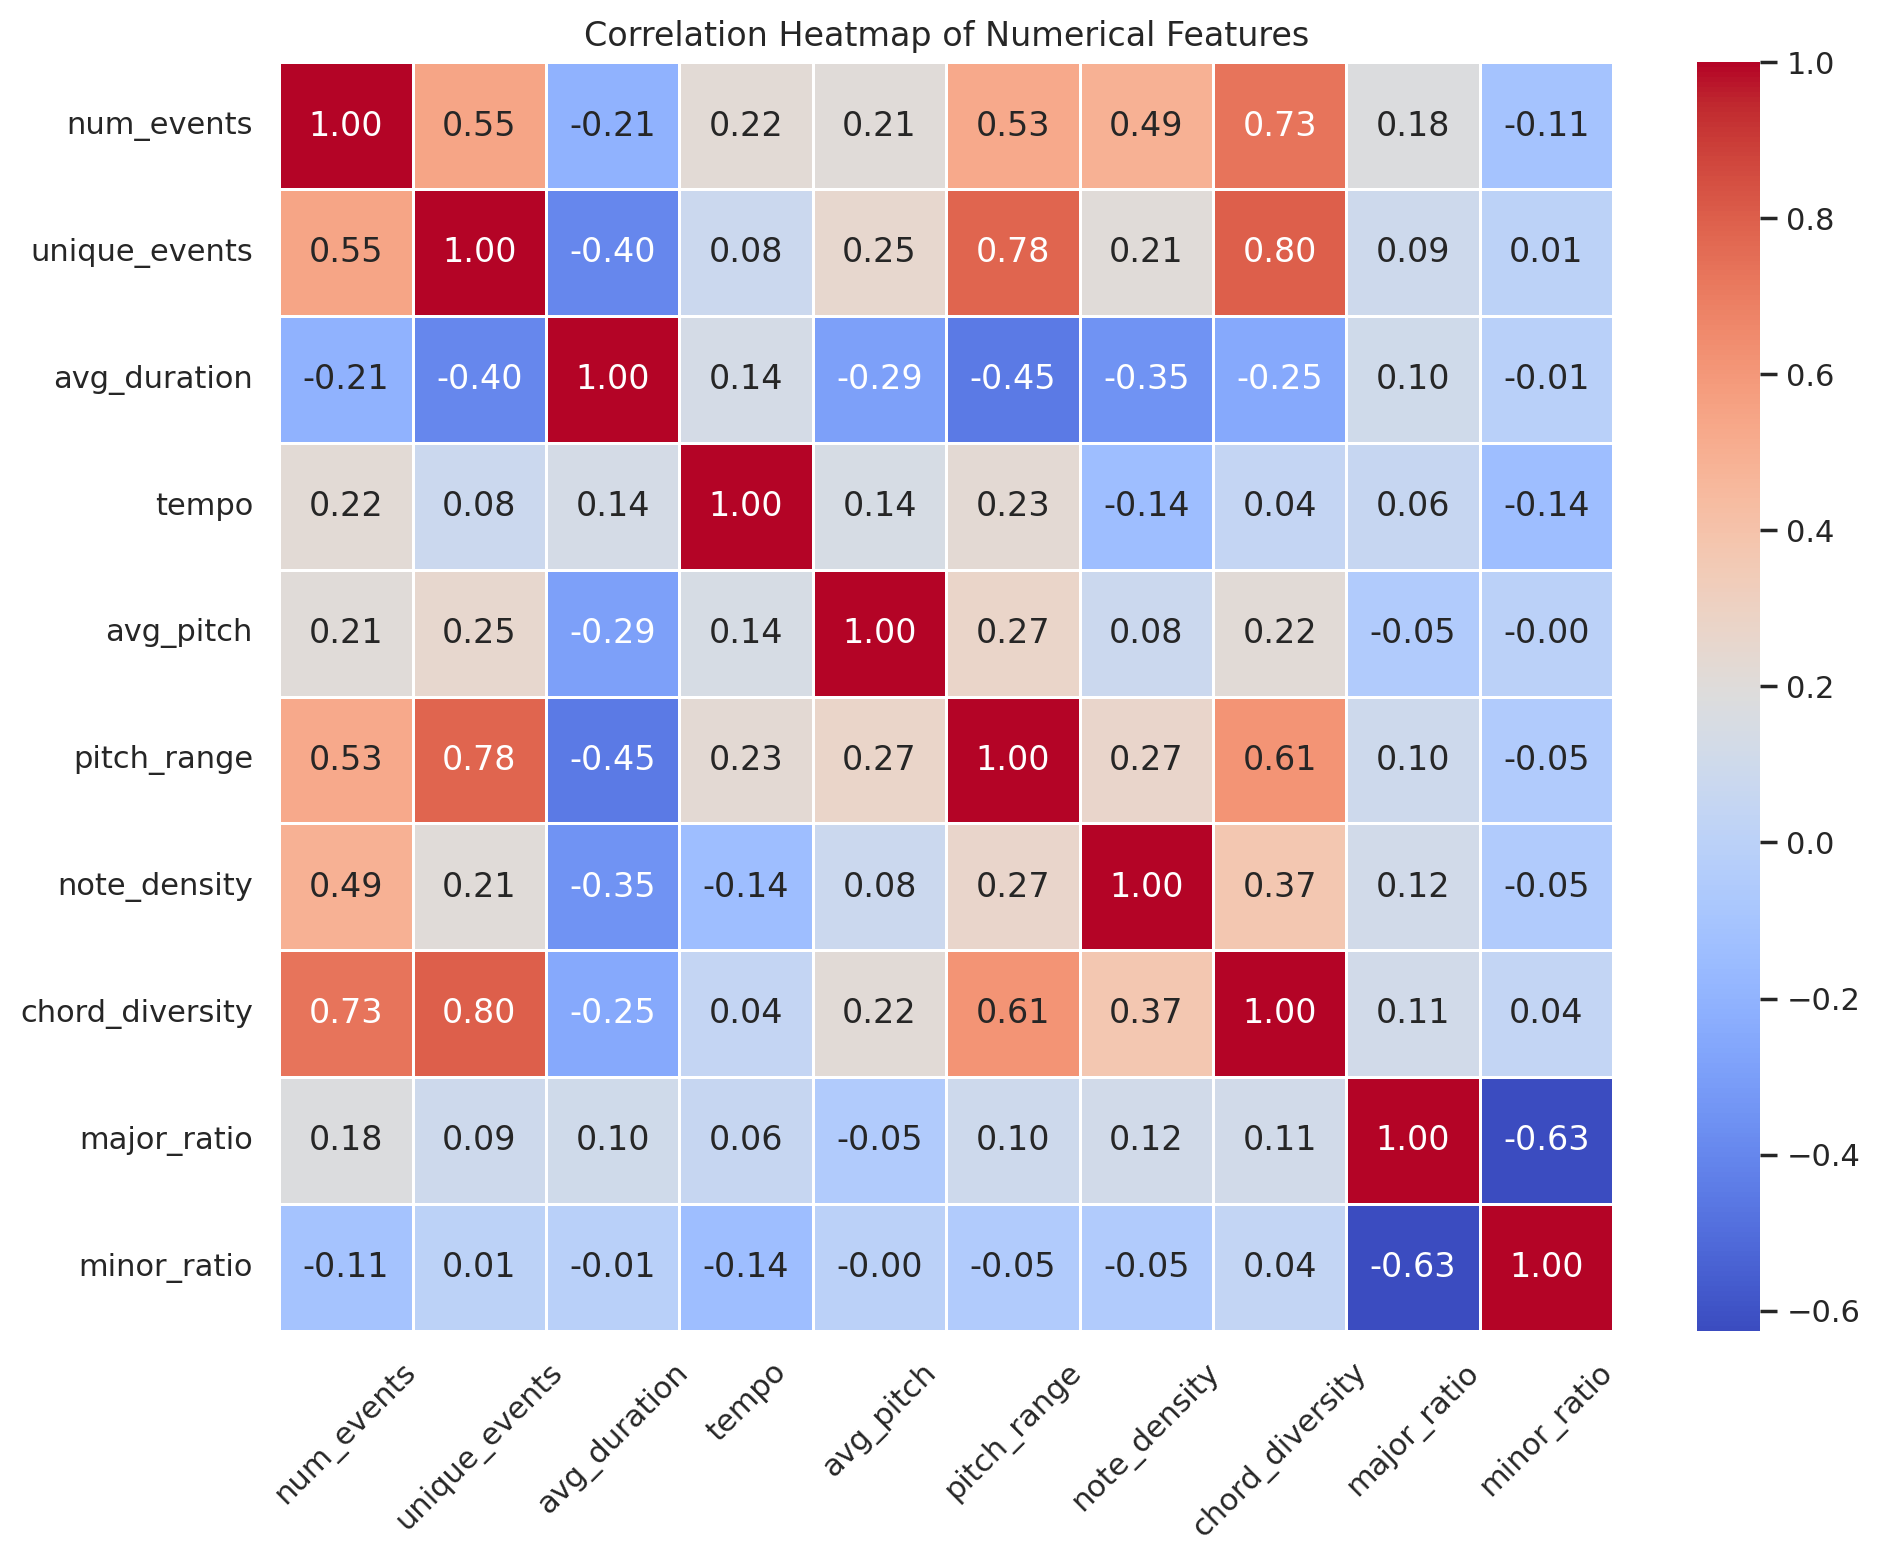

In [11]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Model Training

## Model Evaluation

## Model Optimization